This test is the shallow-water global Barotropic Instability test of Galewsky et al (2004), used also in Scott, Harris, and Polvani (QJ, 2016). It demonstrates how well a dynamical core can represent the vorticial processes at play in the release of this instability and how well a core can maintain the gradients which cause this instability. Here we use it to demonstrate convergence of solutions across resolutions and to also show tracer-PV consistency in FV3.

In [1]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import cartopy.crs as ccrs
import colorsys
import dask #Chunking will be necessary for the larger datasets

In [2]:
large = 28; med = 24; small = 20
params = {'axes.titlesize': small,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': small,
          'axes.titlesize': small,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': med,
          'axes.titlepad': 10,
         'axes.facecolor': 'black'} #For electric background plots
plt.rcParams.update(params)

In [3]:
infile96="/archive/lmh/SHiELD/202103/C96.BTwave/history/0000000000/atmos_daily.nc"
da96=xa.open_dataset(infile96,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR

infile192="/archive/lmh/SHiELD/202103/C192.BTwave/history/0000000000/atmos_daily.nc"
da192=xa.open_dataset(infile192,decode_times=False,chunks={'time': 1}) 

infile384="/archive/lmh/SHiELD/202103/C384.BTwave/history/0000000000/atmos_daily.nc"
da384=xa.open_dataset(infile384,decode_times=False,chunks={'time': 1}) 

infile768="/archive/lmh/SHiELD/202103/C768.BTwave/history/0000000000/atmos_daily.nc"
da768=xa.open_dataset(infile768,decode_times=False,chunks={'time': 1}) 

runnames = ["C96", "C192", "C384", "C768"]

This test case is initialized using a geostrophically-balanced shearing flow that violates the barotropic stability condition (that PV increases monotonically with latitude) with an initial perturbation to release the instability. (The initial meridional wind is zero up to spatial truncation error.)

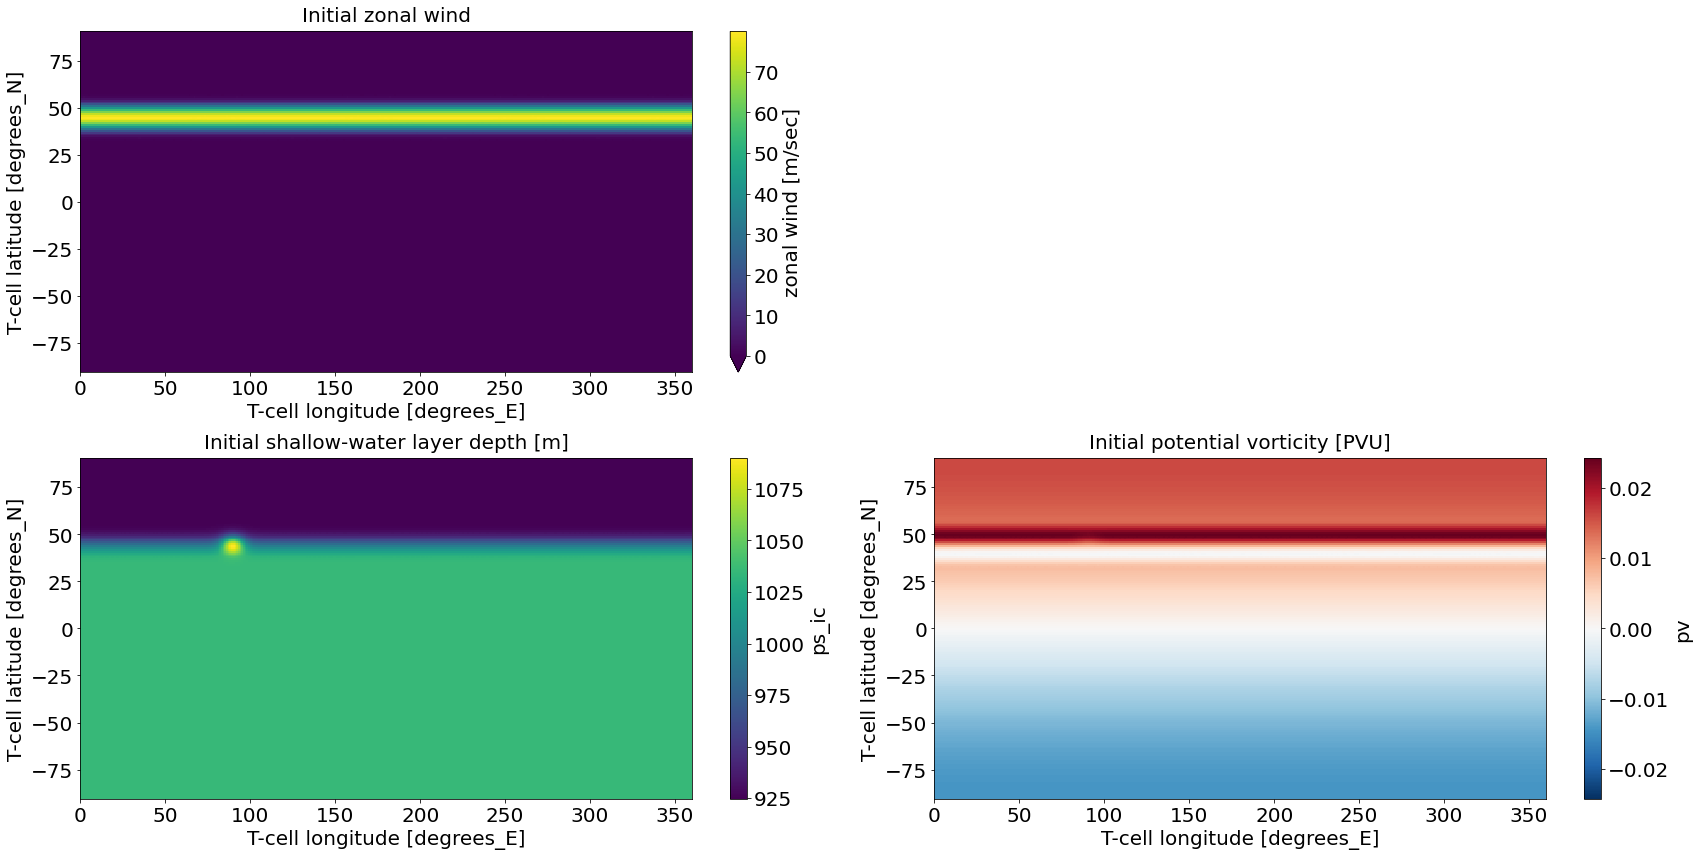

In [4]:
fig = plt.figure(figsize=(24,12))
gs = fig.add_gridspec(2,2)

ax = fig.add_subplot(gs[0,0])
da96.ua_ic.plot(vmin=0)
ax.set_title("Initial zonal wind")

ax = fig.add_subplot(gs[1,0])
(da96.ps_ic/9.81).plot()
ax.set_title("Initial shallow-water layer depth [m]")

ax = fig.add_subplot(gs[1,1])
(da96.pv.isel(time=0)*1.e6).plot()
ax.set_title("Initial potential vorticity [PVU]")


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

In [5]:
#https://stackoverflow.com/questions/58288579/how-to-get-a-lighter-jet-colormap-in-matplotlib
def man_cmap(cmap, value=1.):
    cs = cmap(np.arange(cmap.N))
    hls = np.array([colorsys.rgb_to_hls(*c) for c in cs[:,:3]])
    hls[:,1] *= value
    rgb = np.clip(np.array([colorsys.hls_to_rgb(*c) for c in hls]), 0,1)
    return colors.LinearSegmentedColormap.from_list("", rgb)

Here we see *relative vorticity* in the barotropic wave after the instability has been released and both cyclonic and anticyclonic vortices are visible. The gross features are the same across resolutions (and will remain so until the solutions begin breaking) but more detail is visible at higher resolutions. Note the "chunkiness" in the C96 (top) result, in which contours look a little jagged: this is primarily due to the bilinear interpolation used to create these plots.

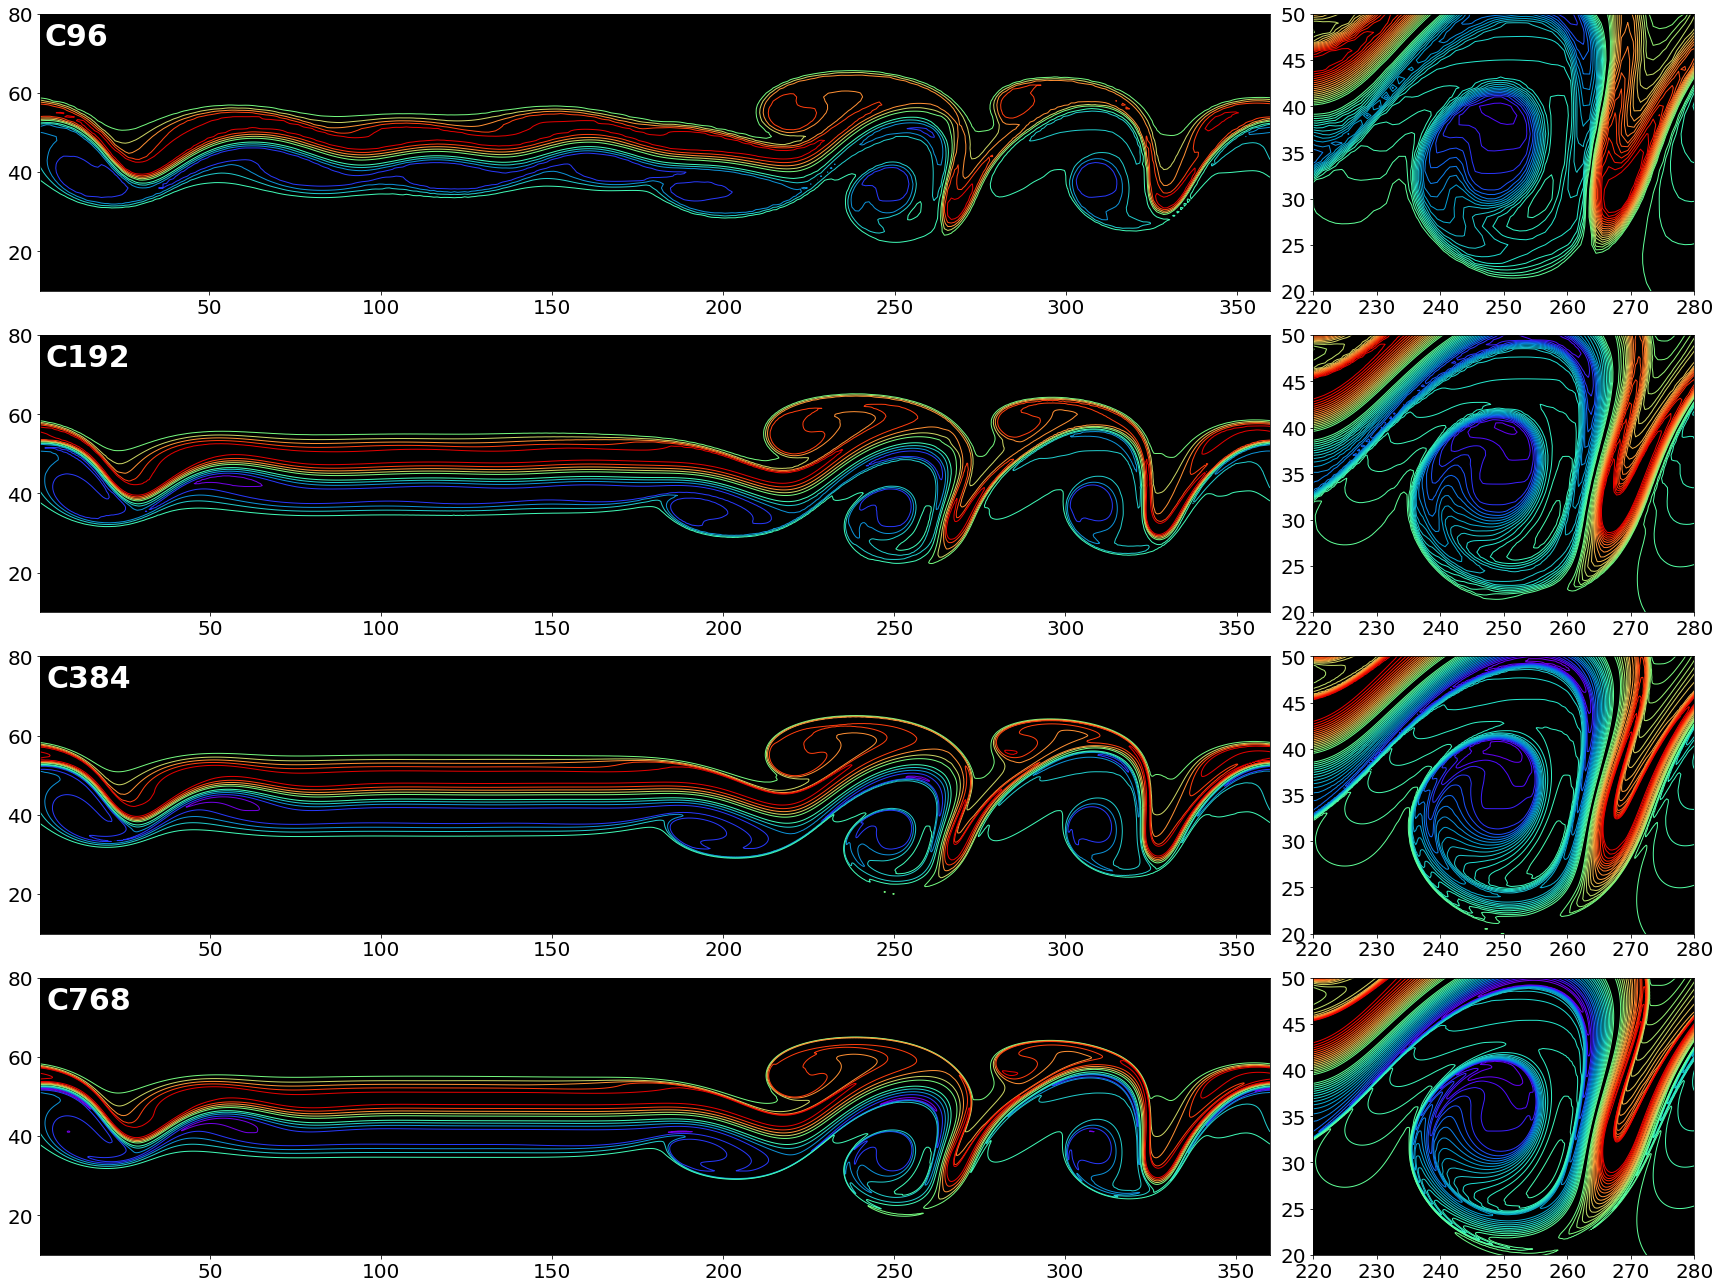

In [6]:
#Plot day 6 (static image---later have a slider for re-plotting)
fig = plt.figure(figsize=(24,18))
gs = fig.add_gridspec(4,4)
clevs=np.append(np.arange(-10e-5,0,2e-5),np.arange(2e-5,11e-5,2e-5))
clevs2=np.append(np.arange(-10e-5,0,0.5e-5),np.arange(2e-5,11e-5,0.5e-5))
cm_rainbow=man_cmap(cm.get_cmap('rainbow'),0.9)

#Add in a plot on grid-cells??
for i, da in enumerate([da96, da192, da384, da768]):

    vort = da['vort'].sel(lat=slice(10,80)).sel(time=4).squeeze()

    ax = fig.add_subplot(gs[i,:-1])
    vort.plot.contour(ax=ax,linewidths=1.0,levels=clevs,colors=cm_rainbow)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    
    ax.text(2,78,runnames[i],color="white",weight="bold",size=30,va="top",ha="left")

    if i == 0:
        ax = fig.add_subplot(gs[i,-1])
        ax1 = ax
    else:
        ax = fig.add_subplot(gs[i,-1], sharex=ax1)
    ax.set_xlim((220,280))
    ax.set_ylim((20,50))
    vort.plot.contour(ax=ax,linewidths=1.0,levels=clevs2,colors=cm_rainbow)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


Here we show the correlation between a tracer field initialized to the same value as the shallow-water PV and the true PV itself. It demonstrates a great strength of FV3: If two variables are advected like a tracer using the same scheme, then their product will also be advected as a scalar. In this case, since the flow is shallow-water (and thus barotropic) and adiabatic, there are no sources of potential vorticity other than diffusion and it should match a conservative scalar. Most notably this demonstrates that FV3 is not falsely generating vorticity, especially through its pressure-gradient force. (The relationship between the scalar and the PV is not perfect due to nonlinear feedback of the divergence damping onto the vorticity---there is no explicit damping applied to tracers.)

Note that using a positive-definite scheme to advect the scalar or a negative-filling method for the scalar would break this relationship since PV is not a positive-definite quantity. This indicates one of the trade-offs in developing numerical models: the dynamical consistency is improved by using the same advection scheme for tracers and dynamical quantities, but there are benefits (especially reduced implicit diffusion) to using the positive-definite scheme for the tracers.

In [7]:
pv=da96['pv'].sel(time=7).squeeze()
sphum=da96['sphum'].sel(time=7).squeeze()

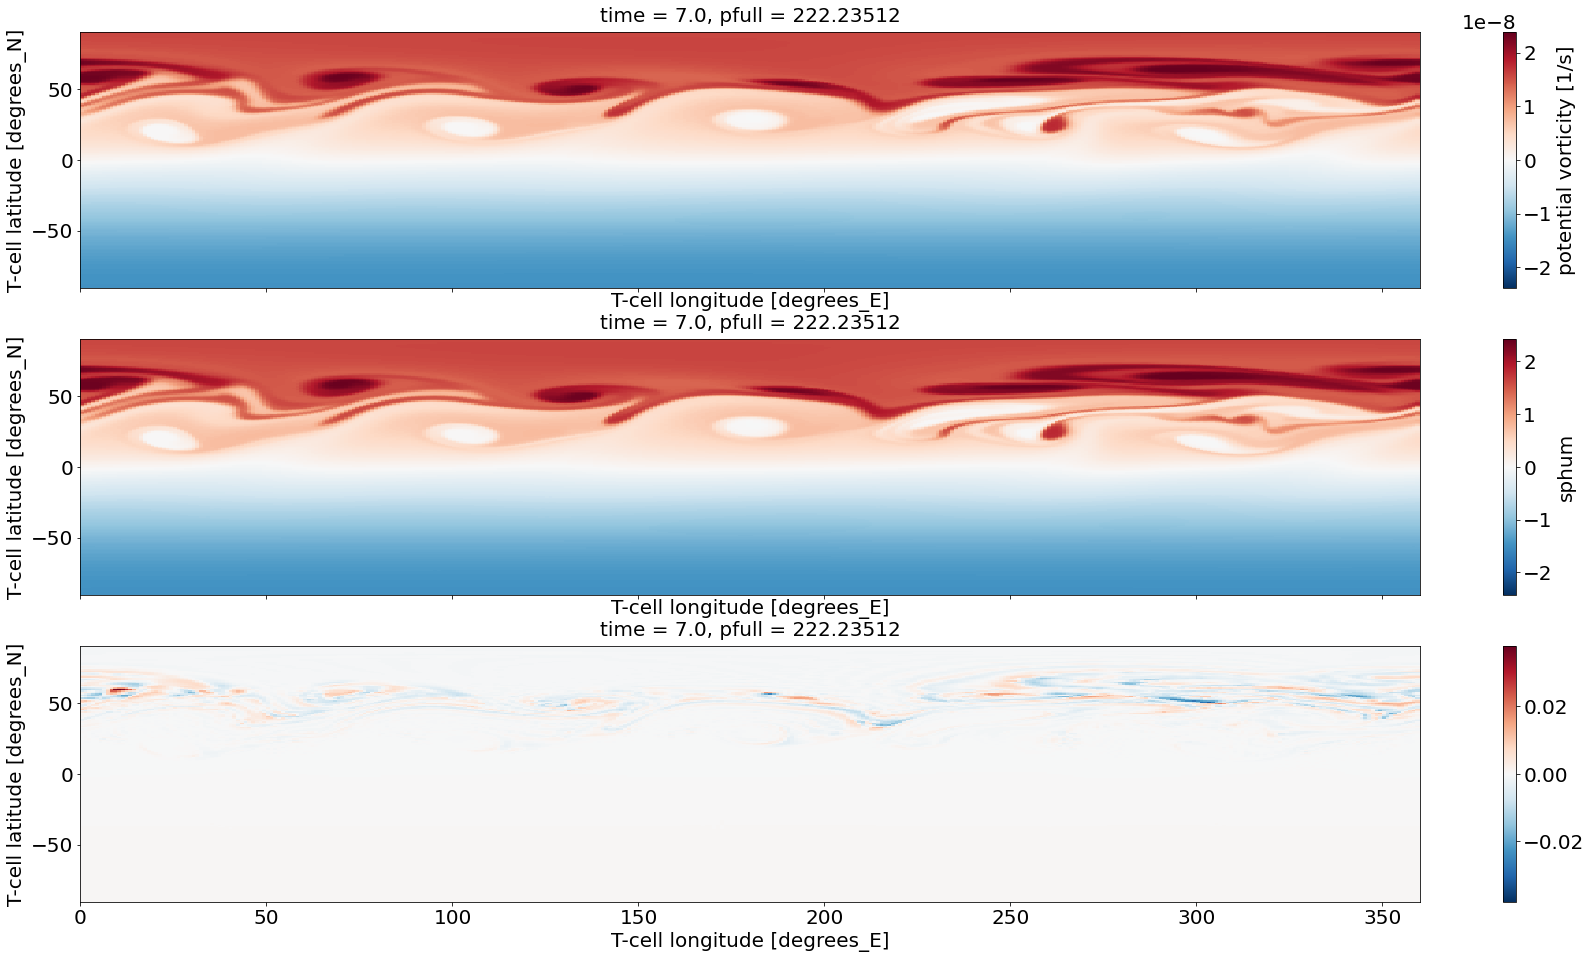

In [8]:
fig, axes = plt.subplots(nrows=3,ncols=1, sharex=True, sharey=True, figsize=(30,16))
pv.plot(ax=axes[0])
(sphum*1e3).plot(ax=axes[1])
dd=(pv*1.e6/9.81-sphum)*1e3
dd.plot(ax=axes[2])#,vmin=-.01,vmax=0.01)

We can compute the rate at which eddy kinetic energy (EKE) builds during the simulation. The EKE builds over the first few days as the instability is released, transferring zonal KE and PE of the initial jet to the eddies. Eventually the amplitude of the eddies (and thereby the EKE) saturates and the eddies begin to dissipate.

Note that C96 builds more quickly and saturates sooner than the others, indicating that at the lower resolution the eddies do develop more quickly as it is harder to maintain the gradients, but also diffuses more quickly as the eddies are more quickly damped by the implicit diffusion. The simulations are essentially converged at C384.

In [9]:
#Eddy kinetic energy of the flow
#assumes inputs are XArray dataarrays
def EKE(ucomp,vcomp,ua_ic,weights):
    ud = ucomp-ua_ic
    ekeL = 0.5*( ud*ud + vcomp*vcomp )
    ekeL = ekeL.weighted(weights)
    eke = ekeL.mean(("lon","lat"))
    return eke

In [10]:
#These computations take a few minutes with Dask but will probably crash your computer without Dask---the C768 dataset is 50GB.
#(Apparently the compute() doesn't necessarily force the computation so it will re-compute every time it plots)
eke_C96 = EKE(da96.ucomp,da96.vcomp,da96.ua_ic,np.cos(np.deg2rad(da96.lat))).compute()
eke_C192 = EKE(da192.ucomp,da192.vcomp,da192.ua_ic,np.cos(np.deg2rad(da192.lat))).compute()
eke_C384 = EKE(da384.ucomp,da384.vcomp,da384.ua_ic,np.cos(np.deg2rad(da384.lat))).compute()
eke_C768 = EKE(da768.ucomp,da768.vcomp,da768.ua_ic,np.cos(np.deg2rad(da768.lat))).compute()


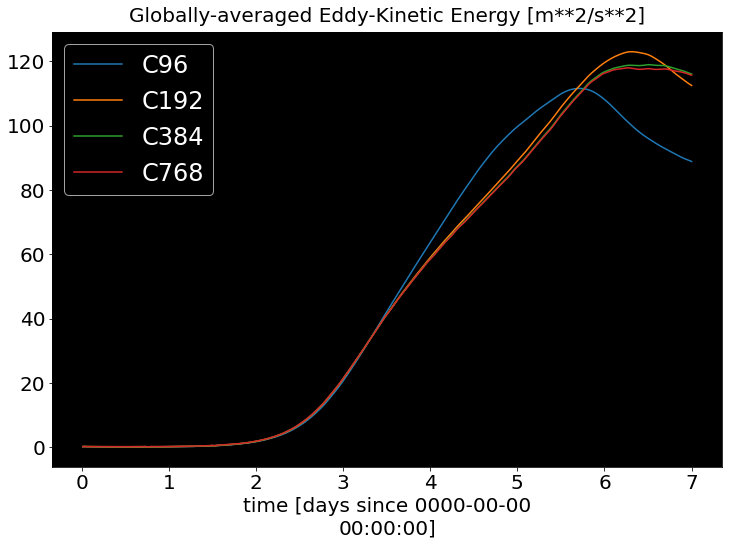

In [11]:
eke_C96.plot(figsize=(12,8),label="C96")
eke_C192.plot(label="C192")
eke_C384.plot(label="C384")
eke_C768.plot(label="C768")
plt.legend(labelcolor="white")
plt.gca().set_title("Globally-averaged Eddy-Kinetic Energy [m**2/s**2]");


No potential vorticity should be created in this flow. Since when PV is created it should create both signs, we instead compute the L2 norm of PV, globally averaged. We find that there is some loss but it is extremely small even at C96, and reduces at increasingly high resolution. Note that this is a **very** strong test, and the L2 norm amplifies small errors.

In [12]:
def totalPV(PV,weights):
    tPV = (PV*PV).weighted(weights).mean(("lon","lat"))
    tPV = np.sqrt(tPV)*1.e6
    return tPV/tPV.isel(time=0)

In [13]:
tPV_C96 = totalPV(da96.pv,np.cos(np.deg2rad(da96.lat))).load()
tPV_C192 = totalPV(da192.pv,np.cos(np.deg2rad(da192.lat))).load()
tPV_C384 = totalPV(da384.pv,np.cos(np.deg2rad(da384.lat))).load()
tPV_C768 = totalPV(da768.pv,np.cos(np.deg2rad(da768.lat))).load()


(0.78, 1.01)

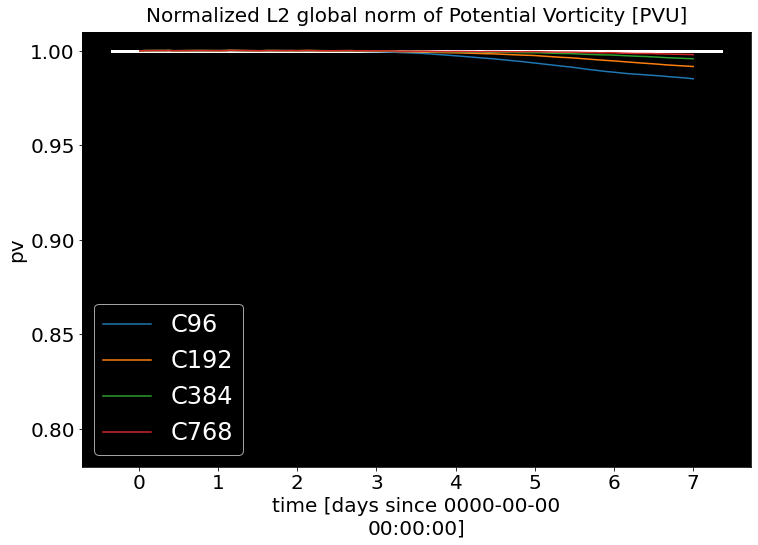

In [14]:
tPV_C96.plot(figsize=(12,8),label="C96")
tPV_C192.plot(label="C192")
tPV_C384.plot(label="C384")
tPV_C768.plot(label="C768")

xl=plt.gca().get_xlim()
plt.gca().plot( plt.gca().get_xlim(), [1,1], linewidth=3, color="white",zorder=-1 )
plt.legend(labelcolor="white")
plt.gca().set_title("Normalized L2 global norm of Potential Vorticity [PVU]");
plt.gca().set_ylim((0.78,1.01))